In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

from datautils import *
# from sphUtils import *
from lossFunctions import *

In [2]:
n = 256
xx = torch.linspace(-1,1,n).type(torch.float64)
yy = torch.linspace(-1,1,n).type(torch.float64)
X,Y = torch.meshgrid(xx,yy,indexing='xy')

positions = torch.vstack((X.flatten(), Y.flatten())).mT

In [3]:
dtype = torch.float64
device = 'cpu'
support = 1.0
targetNeighbors = 16
r = np.sqrt(support**2 / targetNeighbors)
area = np.pi * r ** 2

from torch_geometric.nn import radius
@torch.jit.script
def kernel(q, h):
    C = 7 / np.pi
    b1 = torch.pow(1. - q, 4)
    b2 = 1.0 + 4.0 * q
    return b1 * b2 * C / h**2   

def genParticlesCentered(minCoord, maxCoord, radius, support, packing, dtype = torch.float32, device = 'cpu'):
    area = np.pi * radius**2
    
    gen_position = lambda r, i, j: torch.tensor([r * i, r * j], dtype=dtype, device = device)
        
    diff = maxCoord - minCoord
    center = (minCoord + maxCoord) / 2
    requiredSlices = torch.div(torch.ceil(diff / packing / support).type(torch.int64), 2, rounding_mode='floor')
    
    generatedParticles = []
#     print(requiredSlices)
    for i in range(-requiredSlices[0]-1, requiredSlices[0]+2):
        for j in range(-requiredSlices[1]-1, requiredSlices[1]+2):
            p = center
            g = gen_position(packing * support,i,j)
            pos = p + g
            if pos[0] <= maxCoord[0] + support * 0.2 and pos[1] <= maxCoord[1] + support * 0.2 and \
             pos[0] >= minCoord[0] - support * 0.2 and pos[1] >= minCoord[1] - support * 0.2:
                generatedParticles.append(pos)
                
    return torch.stack(generatedParticles)

def evalPacking(arg):
    packing = torch.tensor(arg, dtype = dtype, device = device)

    minDomain = torch.tensor([\
            -2 * support,\
            -2 * support\
        ], device = device, dtype = dtype)
    maxDomain = torch.tensor([\
             2 * support,\
             2 * support\
        ], device = device, dtype = dtype)

    fluidPosition = genParticlesCentered(minDomain, maxDomain, \
                        r, support, packing, \
                        dtype, device)

    fluidArea = torch.ones(fluidPosition.shape[0], device = device, dtype=dtype) * area
    centralPosition = torch.tensor([[0,0]], device = device, dtype=dtype)

    row, col = radius(centralPosition, fluidPosition, \
                      support, max_num_neighbors = 256)
    fluidNeighbors = torch.stack([row, col], dim = 0)

    fluidDistances = (centralPosition - fluidPosition[fluidNeighbors[0]])
    fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)

    fluidRadialDistances /= support
    rho = scatter(\
            kernel(fluidRadialDistances, support) * fluidArea[fluidNeighbors[1]], \
            fluidNeighbors[1], dim=0, dim_size=centralPosition.size(0), reduce="add")

    return ((1 - rho)**2).detach().cpu().numpy()[0]
packing = minimize(lambda x: evalPacking(x), 0.5, method="nelder-mead").x[0]   
centeredParticles = genParticlesCentered(torch.tensor([-1,-1], dtype = dtype),torch.tensor([1,1],dtype = dtype),r,support, packing, dtype = torch.float64)

In [4]:
positions.shape

torch.Size([65536, 2])

In [5]:
nx = 4
ny = 4
fin = 1
fout = 1

ni = 16
nj = 8

support = 0.25

d = 2

positions_i = torch.rand((ni,d)).type(torch.float64)#fluidPositions[:128,:]
positions_j = torch.rand((nj,d)).type(torch.float64)#fluidPositions[:64,:]

positions_i = positions_j = positions
print(positions_i)
positions_i = torch.tensor([[0,0]]).type(torch.float64)
print(positions_i)

fluidFeatures_i = torch.ones((positions_i.shape[0], fin)).type(torch.float64)
fluidFeatures_j = torch.ones((positions_j.shape[0], fin)).type(torch.float64)
fluidFeatures_i.requires_grad = False
fluidFeatures_j.requires_grad = False

fi, fj = radius(positions_j, positions_i, support, max_num_neighbors = 256, batch_x = None, batch_y = None)

fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
fluidEdgeLengths = (positions_j[fluidEdgeIndex[1]] - positions_i[fluidEdgeIndex[0]])/support

# weight = Parameter(torch.Tensor(nx,ny, fin, fout))
if d==1:
    weight = Parameter(torch.Tensor(nx, fin, fout)).type(torch.float64)
else:
    weight = Parameter(torch.Tensor(nx,ny, fin, fout)).type(torch.float64)
torch.nn.init.xavier_normal_(weight);

with torch.no_grad():
    weight[:,:,:,:] = 1

# debugPrint(fluidFeatures)
#         debugPrint(torch.min(fluidEdgeLengths))

convolution = cutlass.apply

# out = convolution(fluidEdgeIndex, fluidFeatures, fluidEdgeLengths, None, weight, 
#                                             fluidFeatures.shape[0], 0,
#                                         [nx, ny] , ['linear', 'linear'], [False, False], 
#                                         1,1)

# debugPrint(out)




# globalNumerical, globalAnalytical = None, None

# gradcheck(convOp, weight.type(torch.float64))

windowFn = lambda r: torch.ones_like(r) * 2# torch.clamp(torch.pow(1. - r, 4) * (1.0 + 4.0 * r), min = 0)
windowFn = lambda r:torch.clamp(torch.pow(1. - r, 4) * (1.0 + 4.0 * r), min = 0)
# windowFn = None


tensor([[-1.0000, -1.0000],
        [-0.9922, -1.0000],
        [-0.9843, -1.0000],
        ...,
        [ 0.9843,  1.0000],
        [ 0.9922,  1.0000],
        [ 1.0000,  1.0000]], dtype=torch.float64)
tensor([[0., 0.]], dtype=torch.float64)


In [6]:


def ballToCylinder(positions):
    r = torch.linalg.norm(positions, dim = 1)
    xy = torch.linalg.norm(positions[:,:2], dim = 1)
    absz = torch.abs(positions[:,2])

#     debugPrint(r)
#     debugPrint(xy)
#     debugPrint(absz)

    x = positions[:,0]
    y = positions[:,1]
    z = positions[:,2]

    termA = torch.zeros_like(positions)

    eps = 1e-7

    xB = x * r / (xy + eps)
    yB = y * r / (xy + eps)
    zB = 3 / 2 * z
    termB = torch.vstack((xB, yB, zB)).mT

    xC = x * torch.sqrt(3 * r / (r + absz + eps))
    yC = y * torch.sqrt(3 * r / (r + absz + eps))
    zC = torch.sign(z) * r
    termC = torch.vstack((xC, yC, zC)).mT

    mapped = torch.zeros_like(positions)

    maskA = r < eps
    maskB = torch.logical_and(torch.logical_not(maskA), 5/4 * z**2 <= x**2 + y**2)
    maskC = torch.logical_and(torch.logical_not(maskA), torch.logical_not(maskB))

    mapped[maskB] = termB[maskB]
    mapped[maskC] = termC[maskC]

#     debugPrint(mapped)
    return mapped
# debugPrint(cylinderPositions)

def cylinderToCube(positions):
    x = positions[:,0]
    y = positions[:,1]
    z = positions[:,2]
    xy = torch.linalg.norm(positions[:,:2], dim = 1)
    eps = 1e-7

    termA = torch.vstack((torch.zeros_like(x), torch.zeros_like(y), z)).mT
    # debugPrint(termA)

    xB = torch.sign(x) * xy
    yB = 4. / np.pi * torch.sign(x) * xy * torch.atan(y/(x+eps))
    zB = z
    termB = torch.vstack((xB, yB, zB)).mT

    xC = 4. / np.pi * torch.sign(y) * xy * torch.atan(x / (y + eps))
    yC = torch.sign(y) * xy
    zC = z
    termC = torch.vstack((xC, yC, zC)).mT

    maskA = torch.logical_and(torch.abs(x) < eps, torch.abs(y) < eps)
    maskB = torch.logical_and(torch.logical_not(maskA), torch.abs(y) <= torch.abs(x))
    maskC = torch.logical_and(torch.logical_not(maskA), torch.logical_not(maskB))

    # debugPrint(torch.sum(maskA))
    # debugPrint(torch.sum(maskB))
    # debugPrint(torch.sum(maskC))


    mapped = torch.zeros_like(positions)
    mapped[maskA] = termA[maskA]
    mapped[maskB] = termB[maskB]
    mapped[maskC] = termC[maskC]
    
    return mapped

def mapToSpherePreserving(positions):
    cylinderPositions = ballToCylinder(positions)
    cubePositions = cylinderToCube(cylinderPositions)
    return cubePositions


In [34]:
def createData(n, mapping):
    xx = torch.linspace(-1,1,n).type(torch.float64)
    yy = torch.linspace(-1,1,n).type(torch.float64)


    X,Y = torch.meshgrid(xx,yy,indexing='xy')

    xx = X.flatten()
    yy = Y.flatten()
    r2 = xx**2 + yy**2
    if mapping == 'polar':
        xxm = torch.sqrt(xx**2 + yy**2) *2 - 1
        yym = torch.atan2(yy, xx) / np.pi
        xx,yy = xxm, yym
    if mapping == 'preserving':
        positions = torch.vstack((xx,yy,torch.zeros_like(xx))).mT
        mapped = mapToSpherePreserving(positions)
        xx = mapped[:,0]
        yy = mapped[:,1]


    positions = torch.vstack((xx, yy)).mT
    
    return X, Y, positions, torch.ones((positions.shape[0], 1)).type(torch.float64),r2
    
def convolution(ns, rbfs, positions, r2, mapping):
    uA = evalBasisFunction(ns[0], positions[:,0], rbfs[0], False).T
    vA = evalBasisFunction(ns[1], positions[:,1], rbfs[1], False).T
    
    if d==1:
        weight = Parameter(torch.Tensor(ns[0], 1, 1)).type(torch.float64)
    else:
        weight = Parameter(torch.Tensor(ns[0],ns[1], 1, 1)).type(torch.float64)
    torch.nn.init.xavier_normal_(weight);

    with torch.no_grad():
        weight[:,:,:,:] = 1
    convA = torch.einsum('nu, nv, uvio,ni -> no',uA,vA,weight, fluidFeatures_j)
    convA = convA / torch.max(convA)

    if mapping == 'polar' or mapping == 'preserving':
        convA[r2 > 1] = np.nan
    return convA


def plot(ax, X, Y, conv, ns, rbfs, mapping):
    im = ax.pcolormesh(X.detach().cpu().numpy(),Y.detach().cpu().numpy(),convA.reshape(X.shape).detach().cpu().numpy(),vmin = 0, vmax = 1)
    ax.axis('equal')
    ax1_divider = make_axes_locatable(ax)
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    GTcbar = fig.colorbar(im, cax=cax1,orientation='vertical')
    GTcbar.ax.tick_params(labelsize=8) 
    ax.set_title('%s[%2d] x %s[%2d] @ mapping: %s' %(rbfs[0], ns[0], rbfs[1], ns[1], mapping))
    
def plotConv(ax, n, ns, rbfs, mapping):
    X, Y, positions, fluidFeatures_j,r2 = createData(n, mapping)
#     r2 = positions[:,0]**2 + positions[:,1]**2
    convA = convolution(ns, rbfs, positions, r2, mapping)
    
    im = ax.pcolormesh(X.detach().cpu().numpy(),Y.detach().cpu().numpy(),convA.reshape(X.shape).detach().cpu().numpy(),vmin = 0, vmax = 1)
    ax.axis('equal')
    ax1_divider = make_axes_locatable(ax)
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    GTcbar = fig.colorbar(im, cax=cax1,orientation='vertical')
    GTcbar.ax.tick_params(labelsize=8) 
    ax.set_title('%s[%2d] x %s[%2d] @ mapping: %s' %(rbfs[0], ns[0], rbfs[1], ns[1], mapping))
    

<IPython.core.display.Javascript object>


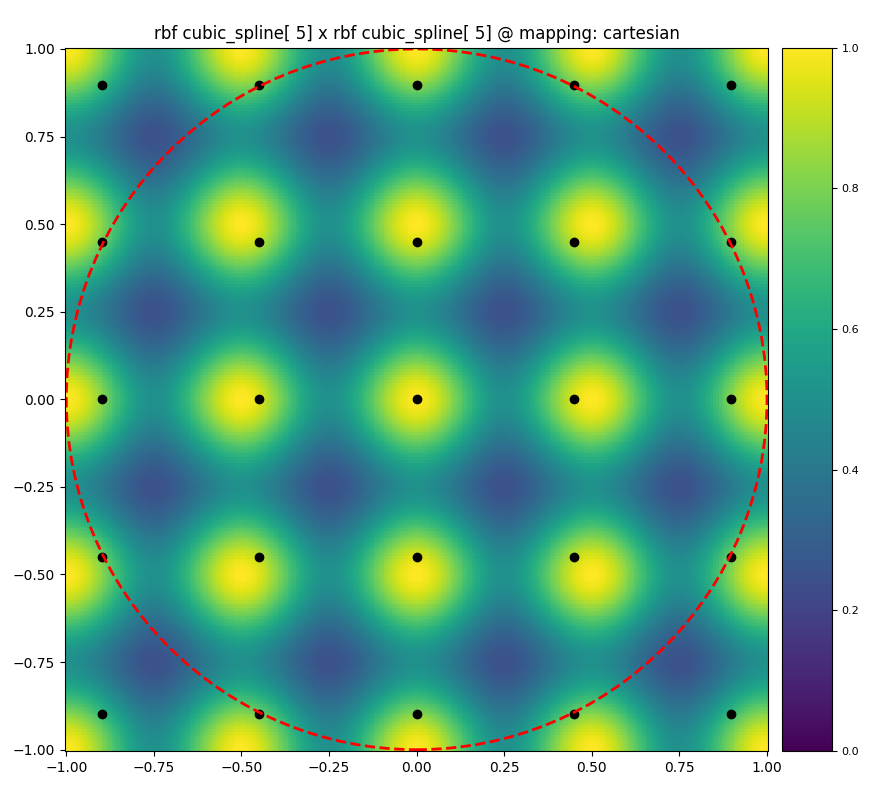

In [62]:
rbfsA = ['rbf cubic_spline', 'rbf cubic_spline']
# rbfsA = ['rbf quartic_spline', 'rbf quartic_spline']
# rbfsA = ['rbf quintic_spline', 'rbf quintic_spline']
# rbfsA = ['rbf gaussian', 'rbf gaussian']
# rbfsA = ['rbf wendland4', 'rbf wendland4']
# rbfsA = ['linear 0.85', 'linear 0.85']
# rbfsA = ['linear', 'rbf cubic_spline']

rbfsB = ['rbf cubic_spline', 'rbf cubic_spline']
rbfsB = ['rbf quartic_spline', 'rbf quartic_spline']
# rbfsB = ['rbf quintic_spline', 'rbf quintic_spline']
# rbfsB = ['rbf gaussian', 'rbf gaussian']
# rbfsB = ['rbf wendland4', 'rbf wendland4']
# rbfsB = ['linear', 'linear']
# rbfsA = ['linear', 'rbf cubic_spline']
# rbfsA = ['rbf cubic_spline', 'linear']

nsA = nsB = [5,5]
mapping = 'cartesian'
# mapping = 'polar'
# mapping = 'preserving'
n = 256

# X, Y, positions, fluidFeatures_j = createData(n, mapping)
# convA = convolution(nsA, rbfsA, positions, r2, mapping)
# convB = convolution(nsB, rbfsB, positions, r2, mapping)
    
fig, axis = plt.subplots(1, 1, figsize=(8*1.09,8), sharex = False, sharey = False, squeeze = False)
plotConv(axis[0,0], 256, nsA, rbfsA, mapping)
# plotConv(axis[0,1], 256, nsB, rbfsB, mapping)

circle1 = plt.Circle((0, 0), 1, color='red', fill = False, ls = '--',lw=2)
# circle2 = plt.Circle((0, 0), 1, color='red', fill = False, ls = '--',lw=2)
axis[0,0].scatter(centeredParticles[:,0], centeredParticles[:,1], c = 'black')
# axis[0,1].scatter(centeredParticles[:,0], centeredParticles[:,1], c = 'black')
axis[0,0].add_patch(circle1)
# axis[0,1].add_patch(circle2)
fig.tight_layout()

In [161]:
support = 1
            self.config['particle']['radius'] = ropt
            self.config['particle']['area'] = np.pi * self.config['particle']['radius']**2
            self.config['particle']['support'] = np.single(np.sqrt(self.config['particle']['area'] / np.pi * self.config['kernel']['targetNeighbors']))

In [188]:
# support = np.sqrt(np.pi * radius **2 / np.pi * targetNeighbors)
targetNeighbors = 12
r = np.sqrt(support**2 / targetNeighbors)
area = np.pi * r ** 2

In [189]:
print(support/r)

3.464101615137755
